# Project 5 - Social Recommendation Systems (CiaoDVD Dataset)
### Aim:
The aim of this project is to build a tool that implements and compares different types of recommendation algorithms on a real-world dataset. The tool should be able to: 
* Load the dataset 
* Run different recommendation algorithms on the dataset 
* Compare and discuss the results, parameter sensitivity

In [1]:
import data_loading_handling as dlh
from matrix_factorization import PMF
from memory_based import MeB
import evalution_metrics as em

import time
import logging
import warnings
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

logging.basicConfig(format='%(asctime)s - %(message)s',
                    level=logging.INFO)  # Logging configuration

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Program Files\Python37\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Tasks: 1. Load the dataset
- Load the CiaoDVD dataset from https://www.librec.net/datasets.html 
- Explore the properties of the graph

In [2]:
path = 'Ciao-DVD-Datasets/movie-ratings.txt'
data_set = dlh.load_dataset(path)
#dataset information
dlh.get_information(data_set)

Users: 17615
Movies: 16121
Categories: 17
Ratings count: 72665
Sparsity: 0.9997441115684126



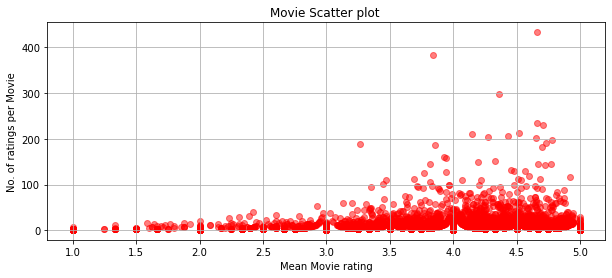

In [3]:
ratings = dlh.ratings_analysis(data_set, True)

In [4]:
genres = dlh.genre_analysis(data_set, False)

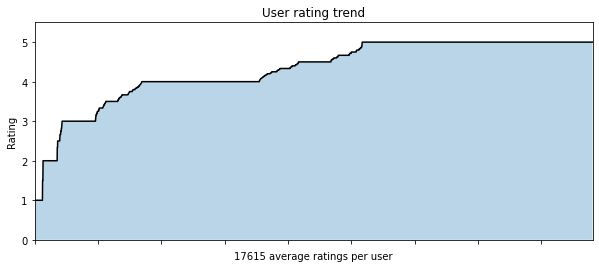

In [5]:
users_avg = dlh.user_analysis(data_set, True)

### Tasks: 2. Implementation
Dataset pre-processing

In [6]:
# User and Movie treshold to be considered as relevant for dataset (this helps to reduce the dataset size)
p_user = 5 # threshold to consider a user relevant
p_movie = 1 # threshold to consider a movie popular
p_rnd = 0.9 # percentage of data to prune 
how = 'm' # Prune by user 'u', by movie 'm' or randomly 'r'

# Here It is got the pruned dataset acording previous parameters
start = time.time()
p_data_set = dlh.prune_dataset(data_set, users_avg, ratings, p_user, p_movie, p_rnd, how)
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))
p_data_set.shape
# New dataset information
dlh.get_information(p_data_set)

2020-05-12 23:06:07,107 - Process done in: 0.01205 seconds


Pruned by Movie


(72665, 4)

Users: 17615
Movies: 16121
Categories: 17
Ratings count: 72665
Sparsity: 0.9997441115684126



In [7]:
# Rating matrix (only the user ratings per movie)
start = time.time()
R_matrix = p_data_set.pivot_table(index = 'userId', columns ='movieId', values = 'movieRating')
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))
index_names = R_matrix.index # Keep the users Id
columns_names = R_matrix.columns # Keep the movies Id
R_matrix = R_matrix.values # Get only the ratings
R_matrix.shape

2020-05-12 23:06:11,303 - Process done in: 4.18020 seconds


(17615, 16121)

In [8]:
# Split Rating matrix into training and testing datasets
start = time.time()
train,test = dlh.split_train_test_custom(R_matrix,0.2)
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-12 23:06:18,782 - Process done in: 7.45477 seconds


### Task 2.1 User based Collaborative Filtering Recommender with pearson correlation coefficient.

In [9]:
# Memory Based RS instance.
bounds = (1, 5)  # max and min boundaries
u2u_pc = MeB(train, index_names, columns_names, bounds)
# user average list
start = time.time()
u2u_pc.get_user_avgs()
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-12 23:06:23,173 - Process done in: 4.35517 seconds


In [10]:
# Pearson Correlation Coeficient
start = time.time()
u2u_pc.pearson_correlation()
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-12 23:33:49,740 - Process done in: 1646.55366 seconds


(17615, 17615)


In [34]:
# Neighborhood selection based on k size
k = 5  # Define the k neighbors size
start = time.time()
u2u_pc.neighborhood(k)
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-13 00:14:06,461 - Process done in: 22.96998 seconds


(17615, 5)


In [35]:
# Prediction Computing: Mean-Centering normalization
start = time.time()
prediction = u2u_pc.predict()
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))
prediction

2020-05-13 00:14:38,471 - Process done in: 31.99178 seconds


array([[4.0039604, 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]])

In [36]:
logging.info('Metrics evaluation')
start = time.time()
print('RMSE: ',em.rmse(test,prediction))
print('MAE: ',em.mae(test,prediction))
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-13 00:14:38,489 - Metrics evaluation


RMSE:  2.862491087874692


2020-05-13 00:14:53,229 - Process done in: 14.73859 seconds


MAE:  2.553532453052331


### Results

#### k = 5
- **RMSE** :  2.862491087874692
- **MAE**:  2.553532453052331

#### k = 15
- **RMSE** :  2.6328692457532776
- **MAE**:  2.2477662162741843

#### k = 25
- **RMSE** :  2.5223215777562404
- **MAE**:  2.106963833429683

#### k = 35
- **RMSE** : 2.454504977470925
- **MAE**:  2.0257092447588376

#### k = 45
- **RMSE** :  2.4096285242867026
- **MAE**:  1.972368287990323

#### k = 55
- **RMSE** : 2.370688696775038  
- **MAE**:  1.928425319949697

### Task 2.2 Probabilistic matrix factorization algorithm.